In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from bcnn_shson_171114 import *
import nn_shson
from shson_exp_manager import *
import h5py
import random

%matplotlib inline


In [2]:
def num_to_onehot(nums, n_labels):
    results = list()
    for i in range(len(nums)):
        res = np.zeros([n_labels])
        res[nums[i]] = 1
        results.append(res)
    return np.asarray(results, dtype = 'float32')
        

In [3]:
mnist = h5py.File('mnist.hdf5', 'r')

random.seed(1337)

perm1 = range(784)
perm2 = range(784)
perm3 = range(784)
perm4 = range(784)
perm5 = range(784)
perm6 = range(784)

random.shuffle(perm1)
random.shuffle(perm2)
random.shuffle(perm3)
random.shuffle(perm4)
random.shuffle(perm5)
random.shuffle(perm6)

print perm1[0:20]
print perm2[0:20]

x_train = list()
x_valid = list()
x_test = list()

x_train.append(mnist['train_data'][()])
x_train.append(mnist['train_data'][()][:, perm1])
x_train.append(mnist['train_data'][()][:, perm2])
x_train.append(mnist['train_data'][()][:, perm3])
x_train.append(mnist['train_data'][()][:, perm4])
x_train.append(mnist['train_data'][()][:, perm5])
x_train.append(mnist['train_data'][()][:, perm6])
t_train = num_to_onehot(mnist['train_label'][()], 10)
x_valid.append(mnist['valid_data'][()])
x_valid.append(mnist['valid_data'][()][:, perm1])
x_valid.append(mnist['valid_data'][()][:, perm2])
x_valid.append(mnist['valid_data'][()][:, perm3])
x_valid.append(mnist['valid_data'][()][:, perm4])
x_valid.append(mnist['valid_data'][()][:, perm5])
x_valid.append(mnist['valid_data'][()][:, perm6])
t_valid = num_to_onehot(mnist['valid_label'][()], 10)
x_test.append(mnist['test_data'][()])
x_test.append(mnist['test_data'][()][:, perm1])
x_test.append(mnist['test_data'][()][:, perm2])
x_test.append(mnist['test_data'][()][:, perm3])
x_test.append(mnist['test_data'][()][:, perm4])
x_test.append(mnist['test_data'][()][:, perm5])
x_test.append(mnist['test_data'][()][:, perm6])
t_test = num_to_onehot(mnist['test_label'][()], 10)

mnist.close()


[290, 476, 531, 412, 667, 470, 656, 123, 167, 378, 357, 729, 324, 327, 271, 681, 155, 75, 755, 316]
[398, 598, 337, 481, 192, 554, 297, 296, 157, 72, 29, 778, 513, 407, 264, 420, 69, 508, 690, 504]


In [2]:
batch_size = 200

In [5]:
def print_accs(accs, ep):
    res = ""
    for acc in accs:
        res += " {:.4f}".format(acc[ep])
    
    print res

# Gal's BCNN

In [2]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.2)))


In [3]:
bcnn_gal = bcnn_model_g([28, 28, 1], [[5, 5, 1, 32],[3, 3, 32, 64]], [True, True], [7 * 7 * 64, 100, 10], mu = 0.1, rhos = [-1., 1., 10.], n_samples = 20, \
                outact = tf.nn.relu, lr = 1e-4, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves_bcnn_gal/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')


conv layer done
conv layer done
(20, ?, 7, 7, 64)
(20, ?, 3136)
fc layer done
fc layer done
(20, ?, 10)
[(<tf.Tensor 'gradients/AddN_14:0' shape=(5, 5, 1, 32) dtype=float32>, <tf.Variable 'conv_layer0/q_pos/mu:0' shape=(5, 5, 1, 32) dtype=float32_ref>), (<tf.Tensor 'gradients/AddN_15:0' shape=(5, 5, 1, 32) dtype=float32>, <tf.Variable 'conv_layer0/q_pos/rho:0' shape=(5, 5, 1, 32) dtype=float32_ref>), (<tf.Tensor 'gradients/AddN_11:0' shape=(3, 3, 32, 64) dtype=float32>, <tf.Variable 'conv_layer1/q_pos/mu:0' shape=(3, 3, 32, 64) dtype=float32_ref>), (<tf.Tensor 'gradients/AddN_12:0' shape=(3, 3, 32, 64) dtype=float32>, <tf.Variable 'conv_layer1/q_pos/rho:0' shape=(3, 3, 32, 64) dtype=float32_ref>), (<tf.Tensor 'gradients/AddN_6:0' shape=(3137, 100) dtype=float32>, <tf.Variable 'fc_layer2/q_pos/mu:0' shape=(3137, 100) dtype=float32_ref>), (<tf.Tensor 'gradients/AddN_8:0' shape=(3137, 100) dtype=float32>, <tf.Variable 'fc_layer2/q_pos/rho:0' shape=(3137, 100) dtype=float32_ref>), (<tf.Ten

In [17]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7


valid_size = batch_size
n_split_valid = len(t_valid) / valid_size

n_epochs = 500
n_batches = len(t_train) / batch_size
patience = 3

taccs_bcnn_gal = list()
#taccs_mean = list()
vaccs_bcnn_gal = list()
epochs_done = list()

for i in range(n_datas):
    vaccs_bcnn_gal.append(list())
    
for d in range(1):
    bcnn_gal.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):
        
        for i in range(n_batches):
#             feed = {bcnn_gal.x: np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 28, 28, 1)), \
#                     bcnn_gal.t: t_train[i*batch_size:(i+1)*batch_size], \
#                     bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5], \
#                     bcnn_gal.n_samples: 1}
            feed = {bcnn_gal.x: np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 28, 28, 1)), \
                    bcnn_gal.t: t_train[i*batch_size:(i+1)*batch_size], \
                    bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]}


            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bcnn_gal.MCdropout(inp = np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 28, 28, 1)), \
                                                   tar = t_train[i*batch_size:(i+1)*batch_size], keep_probs = [0.5, 0.5, 0.5, 0.5], \
                                                   n_samples = 40)                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))

            bcnn_gal.train(feed)

        if ep > 5 and np.mean(taccs_bcnn_gal[-25:]) < taccs_bcnn_gal[-1]:
            if patience == 0:
                last_lr = bcnn_gal.get_lr()
                bcnn_gal.decay_lr()
                patience = 3

                if bcnn_gal.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    epochs_done.append(ep)
                    break
            else:
                patience -= 1
                
        if ep == (n_epochs) - 1: epochs_done.append(ep)
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            valid_mean = 0.
            for j in range(n_split_valid):
                
                valid_mean += bcnn_gal.MCdropout(inp = np.reshape(x_valid[i][j*valid_size:(j+1)*valid_size], (-1, 28, 28, 1)), \
                                                tar =  t_valid[j*valid_size:(j+1)*valid_size], keep_probs = [0.5, 0.5, 0.5, 0.5], \
                                                n_samples = 40)
                
            valid_mean /= n_split_valid
            vaccs_bcnn_gal[i].append(valid_mean)
            str_vacc += " {:.5g}".format(vaccs_bcnn_gal[i][-1])
        
        taccs_bcnn_gal.append(train_accuracy)
        
        print(str_vacc)

        #summary = sess.run(merged, feed_dict ={bcnn_gal.x: np.reshape(x_valid[d], (-1, 28, 28, 1)), \
        #                                       bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]})
        summary = sess.run(merged, feed_dict ={bcnn_gal.x: np.reshape(x_valid[d], (-1, 28, 28, 1)), \
                                               bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]})
        test_writer.add_summary(summary, (d+1)*(ep+1))




ep 0, batch 0, training accuracy 0.11
ep 0, batch 50, training accuracy 0.785
ep 0, batch 100, training accuracy 0.83
ep 0, batch 150, training accuracy 0.9
ep 0, batch 200, training accuracy 0.955
valid accuracy: 0.9539 0.0983 0.0936 0.1031 0.0943 0.0906 0.0813
valid accuracy: 0.9636 0.106 0.092 0.1143 0.1023 0.1252 0.0828
valid accuracy: 0.9725 0.0882 0.1 0.0965 0.1085 0.1105 0.0829
valid accuracy: 0.9743 0.0867 0.116 0.0973 0.1022 0.1219 0.0817
valid accuracy: 0.9777 0.1024 0.1135 0.0905 0.109 0.1178 0.0818
valid accuracy: 0.979 0.1032 0.1174 0.0862 0.1084 0.1233 0.082
valid accuracy: 0.973 0.1032 0.1207 0.0854 0.1164 0.1294 0.0887
valid accuracy: 0.9803 0.1011 0.1125 0.0927 0.1149 0.1219 0.0904
valid accuracy: 0.9823 0.0974 0.1048 0.0959 0.1128 0.0992 0.0838
valid accuracy: 0.9833 0.0956 0.1102 0.1058 0.1034 0.1292 0.0825
valid accuracy: 0.9842 0.1029 0.1104 0.0995 0.1089 0.1183 0.083
valid accuracy: 0.9839 0.1081 0.1149 0.0992 0.1066 0.1174 0.0835
valid accuracy: 0.984 0.1102 0.10

In [13]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7


valid_size = batch_size
n_split_valid = len(t_valid) / valid_size

n_epochs = 500
n_batches = len(t_train) / batch_size
patience = 3

taccs_bcnn_gal = list()
#taccs_mean = list()
vaccs_bcnn_gal = list()
epochs_done = list()

for i in range(n_datas):
    vaccs_bcnn_gal.append(list())
    
for d in range(n_datas):
    bcnn_gal.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):
        
        for i in range(n_batches):
#             feed = {bcnn_gal.x: np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 28, 28, 1)), \
#                     bcnn_gal.t: t_train[i*batch_size:(i+1)*batch_size], \
#                     bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5], \
#                     bcnn_gal.n_samples: 1}
            feed = {bcnn_gal.x: np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 28, 28, 1)), \
                    bcnn_gal.t: t_train[i*batch_size:(i+1)*batch_size], \
                    bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]}


            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bcnn_gal.MCdropout(inp = np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 28, 28, 1)), \
                                                   tar = t_train[i*batch_size:(i+1)*batch_size], keep_probs = [0.5, 0.5, 0.5, 0.5], \
                                                   n_samples = 10)                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))

            bcnn_gal.train(feed)

        if ep > 5 and np.mean(taccs_bcnn_gal[-25:]) < taccs_bcnn_gal[-1]:
            if patience == 0:
                last_lr = bcnn_gal.get_lr()
                bcnn_gal.decay_lr()
                patience = 3

                if bcnn_gal.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    epochs_done.append(ep)
                    break
            else:
                patience -= 1
                
        if ep == (n_epochs) - 1: epochs_done.append(ep)
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            valid_mean = 0.
            for j in range(n_split_valid):
                
                valid_mean += bcnn_gal.MCdropout(inp = np.reshape(x_valid[i][j*valid_size:(j+1)*valid_size], (-1, 28, 28, 1)), \
                                                tar =  t_valid[j*valid_size:(j+1)*valid_size], keep_probs = [0.5, 0.5, 0.5, 0.5], \
                                                n_samples = 10)
                
            valid_mean /= n_split_valid
            vaccs_bcnn_gal[i].append(valid_mean)
            str_vacc += " {:.5g}".format(vaccs_bcnn_gal[i][-1])
        
        taccs_bcnn_gal.append(train_accuracy)
        
        print(str_vacc)

        #summary = sess.run(merged, feed_dict ={bcnn_gal.x: np.reshape(x_valid[d], (-1, 28, 28, 1)), \
        #                                       bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]})
        summary = sess.run(merged, feed_dict ={bcnn_gal.x: np.reshape(x_valid[d], (-1, 28, 28, 1)), \
                                               bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]})
        test_writer.add_summary(summary, (d+1)*(ep+1))




ep 0, batch 0, training accuracy 0.105
ep 0, batch 50, training accuracy 0.82
ep 0, batch 100, training accuracy 0.83
ep 0, batch 150, training accuracy 0.9
ep 0, batch 200, training accuracy 0.94
valid accuracy: 0.9332 0.0963 0.0967 0.1102 0.0939 0.0933 0.0743
valid accuracy: 0.9547 0.1049 0.0927 0.1203 0.0985 0.1107 0.0708
valid accuracy: 0.9372 0.1046 0.1038 0.117 0.1055 0.1038 0.0864
valid accuracy: 0.9703 0.1151 0.1018 0.1219 0.1046 0.1052 0.0805
valid accuracy: 0.9724 0.1173 0.1083 0.1165 0.1076 0.116 0.0851
valid accuracy: 0.9768 0.1113 0.1027 0.1179 0.1141 0.1205 0.0885
valid accuracy: 0.9784 0.1109 0.1086 0.1165 0.1076 0.1254 0.0858
valid accuracy: 0.9808 0.1173 0.106 0.1158 0.1139 0.1217 0.1001
valid accuracy: 0.9784 0.1127 0.1043 0.1199 0.1147 0.1245 0.0931
valid accuracy: 0.9812 0.0995 0.1021 0.1181 0.1108 0.1256 0.0959
valid accuracy: 0.9831 0.1104 0.1051 0.1052 0.1119 0.1233 0.0926
valid accuracy: 0.9827 0.107 0.1084 0.1177 0.108 0.1331 0.0945
valid accuracy: 0.9858 0.112

In [16]:
vaccs_bcnn_gal_add = list()
for i in range(n_datas):
    vaccs_bcnn_gal_add.append(list())

for i in range(n_datas): 
    valid_mean = 0.
    for j in range(n_split_valid):

        valid_mean += bcnn_gal.MCdropout(inp = np.reshape(x_valid[i][j*valid_size:(j+1)*valid_size], (-1, 28, 28, 1)), \
                                        tar =  t_valid[j*valid_size:(j+1)*valid_size], keep_probs = [0.5, 0.5, 0.5, 0.5], \
                                        n_samples = 40)

    valid_mean /= n_split_valid
    vaccs_bcnn_gal_add[i].append(valid_mean)
    str_vacc += " {:.5g}".format(vaccs_bcnn_gal_add[i][-1])
    
print str_vacc

valid accuracy: 0.0578 0.1106 0.0945 0.0991 0.1988 0.3516 0.9546 0.054 0.112 0.095 0.099 0.2076 0.3775 0.9605


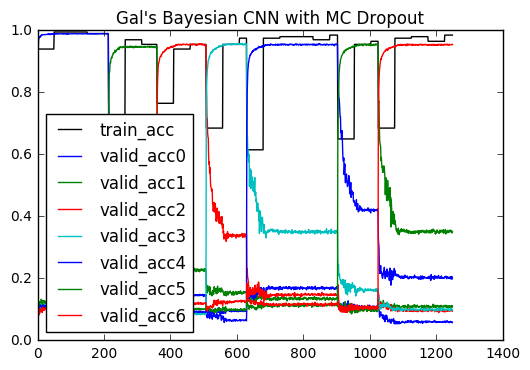

In [14]:
plt.title('Gal\'s Bayesian CNN with MC Dropout')
plt.plot(taccs_bcnn_gal, 'k')
plt.plot(vaccs_bcnn_gal[0], 'b')
plt.plot(vaccs_bcnn_gal[1], 'g')
plt.plot(vaccs_bcnn_gal[2], 'r')
plt.plot(vaccs_bcnn_gal[3], 'c')
plt.plot(vaccs_bcnn_gal[4], 'b')
plt.plot(vaccs_bcnn_gal[5], 'g')
plt.plot(vaccs_bcnn_gal[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

# Blundell version

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-1.0, 5.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = True, train_rho = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

# train_writer = tf.train.SummaryWriter(savedir + 'train', sess.graph)
# test_writer = tf.train.SummaryWriter(savedir + 'test')

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')


In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())
    
for d in range(n_datas):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):
        bnn.reset_klrw()

        for i in range(n_batches):
            
            bnn.decay_klrw()

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))
                
            bnn.train(feed)

        fs_mean.append(np.mean(fs[-n_batches:]))

        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3

                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
                
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))




In [ ]:
coeff_klrw = 1 / n_batches

plt.plot(fs, 'r')
plt.plot(qs*coeff_klrw, 'b')
plt.plot(ps*coeff_klrw, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')


plt.legend(['f', 'q', 'p', 'l'])
plt.show()

In [ ]:
plt.title('Blundell\'s Bayesian NN')
plt.plot(taccs, 'k')
plt.plot(vaccs[0], 'tab:blue')
plt.plot(vaccs[1], 'tab:orange')
plt.plot(vaccs[2], 'tab:green')
plt.plot(vaccs[3], 'tab:red')
plt.plot(vaccs[4], 'tab:purple')
plt.plot(vaccs[5], 'tab:brown')
plt.plot(vaccs[6], 'tab:pink')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

# Online version

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = False, train_rho = True, only_loglike = False)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            bnn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3

                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1


        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    bnn.update_prior()
    #bnn.print_params()




In [ ]:
plt.plot(fs, 'r')
plt.plot(qs, 'b')
plt.plot(ps, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')

plt.legend(['f', 'q', 'p', 'l'])
plt.show()

In [ ]:
taccs_BNN_OL = taccs
vaccs_BNN_OL = vaccs

plt.title('Bayesian NN')

plt.plot(taccs_BNN_OL, 'k')
plt.plot(vaccs_BNN_OL[0], 'b')
plt.plot(vaccs_BNN_OL[1], 'g')
plt.plot(vaccs_BNN_OL[2], 'r')
plt.plot(vaccs_BNN_OL[3], 'c')
plt.plot(vaccs_BNN_OL[4], 'b')
plt.plot(vaccs_BNN_OL[5], 'g')
plt.plot(vaccs_BNN_OL[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_BNN_OL, 0)
print_accs(vaccs_BNN_OL, 199)
print_accs(vaccs_BNN_OL, 399)
print_accs(vaccs_BNN_OL, 599)
print_accs(vaccs_BNN_OL, 799)
print_accs(vaccs_BNN_OL, 999)
print_accs(vaccs_BNN_OL, 1199)
print_accs(vaccs_BNN_OL, 1399)

# Online version + EWC with rho_grad

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = False, train_rho = True, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

In [ ]:
print bnn.p_params

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            bnn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3

                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1


        if ep % 50 == 0: bnn.print_ewcgrads(feed)
        
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    bnn.update_prior()
    #bnn.print_params()




In [ ]:
plt.plot(fs, 'r')
plt.plot(qs, 'b')
plt.plot(ps, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')

plt.legend(['f', 'q', 'p', 'l'])
plt.show()

In [ ]:
taccs_BNN_MG = taccs
vaccs_BNN_MG = vaccs

plt.title('Bayesian NN with Modified Gradients')
plt.plot(taccs_BNN_MG, 'k')
plt.plot(vaccs_BNN_MG[0], 'b')
plt.plot(vaccs_BNN_MG[1], 'g')
plt.plot(vaccs_BNN_MG[2], 'r')
plt.plot(vaccs_BNN_MG[3], 'c')
plt.plot(vaccs_BNN_MG[4], 'b')
plt.plot(vaccs_BNN_MG[5], 'g')
plt.plot(vaccs_BNN_MG[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_BNN_MG, 0)
print_accs(vaccs_BNN_MG, 199)
print_accs(vaccs_BNN_MG, 399)
print_accs(vaccs_BNN_MG, 599)
print_accs(vaccs_BNN_MG, 799)
print_accs(vaccs_BNN_MG, 999)
print_accs(vaccs_BNN_MG, 1199)
print_accs(vaccs_BNN_MG, 1399)

In [ ]:
taccs_BNN_MG = taccs
vaccs_BNN_MG = vaccs

plt.title('Bayesian NN with Modified Gradients')
plt.plot(taccs_BNN_MG, 'k')
plt.plot(vaccs_BNN_MG[0], 'b')
plt.plot(vaccs_BNN_MG[1], 'g')
plt.plot(vaccs_BNN_MG[2], 'r')
plt.plot(vaccs_BNN_MG[3], 'c')
plt.plot(vaccs_BNN_MG[4], 'b')
plt.plot(vaccs_BNN_MG[5], 'g')
plt.plot(vaccs_BNN_MG[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_BNN_MG, 0)
print_accs(vaccs_BNN_MG, 199)
print_accs(vaccs_BNN_MG, 399)
print_accs(vaccs_BNN_MG, 599)
print_accs(vaccs_BNN_MG, 799)
print_accs(vaccs_BNN_MG, 999)
print_accs(vaccs_BNN_MG, 1199)
print_accs(vaccs_BNN_MG, 1399)

# Normal NN

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
nn = nn_shson.nn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, only_loglike = True, ewc = False)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 2000
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    nn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {nn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    nn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_l = nn.get_fqpl(feed)
            fs.append(v_f), ls.append(v_l)

            nn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = nn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                #print("f : {}, l : {}".format(v_f, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = nn.get_lr()
                nn.decay_lr()
                patience = 3

                if nn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
        
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(nn.validate({nn.x: x_valid[i], nn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={nn.x: x_valid[d], nn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    nn.update_prior()
    #bnn.print_params()




In [ ]:
taccs_nNN = taccs
vaccs_nNN = vaccs

plt.title('Normal NN')

plt.plot(taccs_nNN, 'k')
plt.plot(vaccs_nNN[0], 'b')
plt.plot(vaccs_nNN[1], 'g')
plt.plot(vaccs_nNN[2], 'r')
plt.plot(vaccs_nNN[3], 'c')
plt.plot(vaccs_nNN[4], 'b')
plt.plot(vaccs_nNN[5], 'g')
plt.plot(vaccs_nNN[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_nNN, 0)
print_accs(vaccs_nNN, 1999)
print_accs(vaccs_nNN, 3999)
print_accs(vaccs_nNN, 5999)
print_accs(vaccs_nNN, 7999)
print_accs(vaccs_nNN, 9999)
print_accs(vaccs_nNN, 11999)
print_accs(vaccs_nNN, 13999)

# Normal NN + EWC

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
enn = nn_shson.nn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 2000
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    enn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {enn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    enn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_l = enn.get_fqpl(feed)
            fs.append(v_f), ls.append(v_l)

            enn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = enn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                #print("f : {}, l : {}".format(v_f, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = enn.get_lr()
                enn.decay_lr()
                patience = 3

                if enn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
        
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(enn.validate({enn.x: x_valid[i], enn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={enn.x: x_valid[d], enn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    enn.update_prior()
    #bnn.print_params()




In [ ]:
taccs_NNEWC = taccs
vaccs_NNEWC = vaccs

plt.title('Normal NN with EWC')
plt.plot(taccs_NNEWC, 'k')
plt.plot(vaccs_NNEWC[0], 'b')
plt.plot(vaccs_NNEWC[1], 'g')
plt.plot(vaccs_NNEWC[2], 'r')
plt.plot(vaccs_NNEWC[3], 'c')
plt.plot(vaccs_NNEWC[4], 'b')
plt.plot(vaccs_NNEWC[5], 'g')
plt.plot(vaccs_NNEWC[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_NNEWC, 0)
print_accs(vaccs_NNEWC, 1999)
print_accs(vaccs_NNEWC, 3999)
print_accs(vaccs_NNEWC, 5999)
print_accs(vaccs_NNEWC, 7999)
print_accs(vaccs_NNEWC, 9999)
print_accs(vaccs_NNEWC, 11999)
print_accs(vaccs_NNEWC, 13999)

In [ ]:
taccs_NNEWC = taccs
vaccs_NNEWC = vaccs

plt.title('Normal NN with EWC')
plt.plot(taccs_NNEWC, 'k')
plt.plot(vaccs_NNEWC[0], 'b')
plt.plot(vaccs_NNEWC[1], 'g')
plt.plot(vaccs_NNEWC[2], 'r')
plt.plot(vaccs_NNEWC[3], 'c')
plt.plot(vaccs_NNEWC[4], 'b')
plt.plot(vaccs_NNEWC[5], 'g')
plt.plot(vaccs_NNEWC[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_NNEWC, 0)
print_accs(vaccs_NNEWC, 1999)
print_accs(vaccs_NNEWC, 3999)
print_accs(vaccs_NNEWC, 5999)
print_accs(vaccs_NNEWC, 7999)
print_accs(vaccs_NNEWC, 9999)
print_accs(vaccs_NNEWC, 11999)
print_accs(vaccs_NNEWC, 13999)